# Toffoli Optimization Benchmarking on IBMQ Jakarta

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cirq
from qiskit import *
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import qiskit.quantum_info as qi
sys.path.append('../..')
from benchmarking import generate_qpt_circuits, run_qpt_job, compute_fidelity, compute_fidelity_job_id, PulseGates, Gates

### Load Credentials and APIs

In [2]:
IBMQ.load_account()
provider = IBMQ.providers()[1]
backend = provider.get_backend('ibmq_jakarta')

In [3]:
ss_api_key = ""
ss_host = ""  # not necessary

### Get Measurement Error Calibration Circuits

In [19]:
qr = QuantumRegister(7)
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=[[0, 1, 3]], qr=qr, circlabel='mcal')

In [22]:
# meas_cal_job = execute(meas_calibs, backend=backend, optimization_level=0, shots=10000)  # uncomment to run

In [ ]:
meas_cal_job = backend.retrieve_job("624f68bf182d022dbd4c3007")

In [21]:
print(meas_cal_job.job_id())

624f68bf182d022dbd4c3007


In [ ]:
cal_results = meas_cal_job.result()

In [ ]:
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=[[0, 1, 3]])

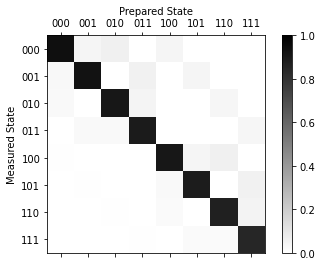

In [50]:
meas_fitter.plot_calibration(0)

In [51]:
meas_filter = meas_fitter.filter

### Get Toffoli Gate Implementations

In [4]:
basic_toffoli_circ = QuantumCircuit(7)
basic_toffoli_circ.ccx(0, 1, 3)

# Get the ideal Toffoli gate unitary operator
target_circ = QuantumCircuit(3)
target_circ.ccx(0, 1, 2)
target_unitary = qi.Operator(target_circ)

In [5]:
gate_gen = PulseGates(backend, ss_host, ss_api_key)

In [6]:
opt_linear_toffoli = gate_gen.get_optimized_linear_toffoli_no_sandwich(qubits=[0, 1, 3], target="ibmq_jakarta_qpu")
can_linear_toffoli = gate_gen.get_canonical_linear_toffoli(qubits=[0, 1, 3])

None


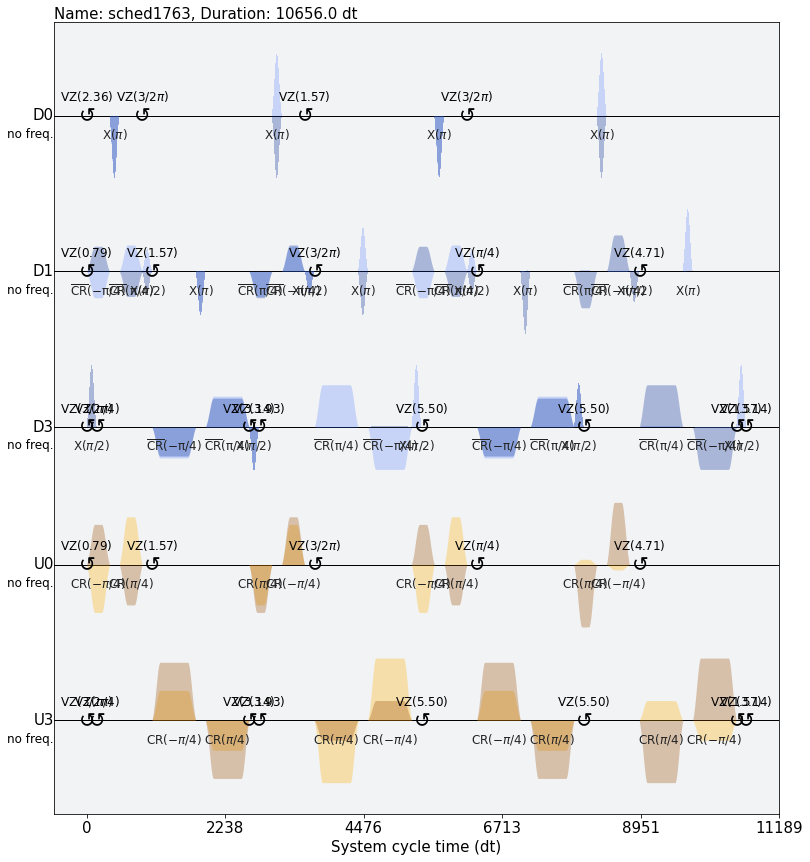

In [7]:
opt_linear_toffoli.draw()

### Prepare Benchmarking Runs

In [8]:
opt_qpt_circuits = generate_qpt_circuits(circuit=basic_toffoli_circ, qubits=[0, 1, 3], backend=backend)

transpiled_opt_qpt_circuits = []

for qpt_circuit in opt_qpt_circuits:
    qpt_circuit.add_calibration('ccx', [0, 1, 3], opt_linear_toffoli)
    transpiled_qpt_circuit = transpile(qpt_circuit, backend=backend, optimization_level=0)
    transpiled_opt_qpt_circuits.append(transpiled_qpt_circuit)

/home/maxab/anaconda3/envs/micro/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:465: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += preparation(prep_label[j], prep_qubits[j])
/home/maxab/anaconda3/envs/micro/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/home/maxab/anaconda3/envs/micro/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circ

In [9]:
can_qpt_circuits = generate_qpt_circuits(circuit=basic_toffoli_circ, qubits=[0, 1, 3], backend=backend)

transpiled_can_qpt_circuits = []

for qpt_circuit in can_qpt_circuits:
    qpt_circuit.add_calibration('ccx', [0, 1, 3], can_linear_toffoli)
    transpiled_qpt_circuit = transpile(qpt_circuit, backend=backend, optimization_level=0)
    transpiled_can_qpt_circuits.append(transpiled_qpt_circuit)

In [10]:
transpiled_can_qpt_circuits[100].draw()

/home/maxab/anaconda3/envs/micro/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


global phase: 3π/4
                                                 ░       ░             ┌─┐»
q_0 -> 0 ────────────────────────────────────────░───■───░─────────────┤M├»
                                                 ░   │   ░ ┌─────────┐ └╥┘»
q_1 -> 1 ────────────────────────────────────────░───■───░─┤ Rz(π/2) ├──╫─»
                                                 ░   │   ░ └─────────┘  ║ »
q_2 -> 2 ────────────────────────────────────────░───┼───░──────────────╫─»
         ┌─────────┐┌────┐┌─────────┐┌─────────┐ ░ ┌─┴─┐ ░ ┌──────────┐ ║ »
q_3 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├─░─┤ X ├─░─┤ Rz(-π/2) ├─╫─»
         └─────────┘└────┘└─────────┘└─────────┘ ░ └───┘ ░ └──────────┘ ║ »
q_4 -> 4 ────────────────────────────────────────░───────░──────────────╫─»
                                                 ░       ░              ║ »
q_5 -> 5 ────────────────────────────────────────░───────░──────────────╫─»
                                                 ░       ░              ║ »
q_6 -> 6 ────────────────────────────────────────░───────░──────────────╫─»
                                                 ░       ░              ║ »
   c1: 3/═══════════════════════════════════════════════════════════════╩═»
                                                                        0 »
«                                                
«q_0 -> 0 ───────────────────────────────────────
«            ┌────┐  ┌─────────┐           ┌─┐   
«q_1 -> 1 ───┤ √X ├──┤ Rz(π/2) ├───────────┤M├───
«            └────┘  └─────────┘           └╥┘   
«q_2 -> 2 ──────────────────────────────────╫────
«         ┌─────────┐   ┌────┐  ┌─────────┐ ║ ┌─┐
«q_3 -> 3 ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├─╫─┤M├
«         └─────────┘   └────┘  └─────────┘ ║ └╥┘
«q_4 -> 4 ──────────────────────────────────╫──╫─
«                                           ║  ║ 
«q_5 -> 5 ──────────────────────────────────╫──╫─
«                                           ║  ║ 
«q_6 -> 6 ──────────────────────────────────╫──╫─
«                                           ║  ║ 
«   c1: 3/══════════════════════════════════╩══╩═
«                                           1  2

In [11]:
ibm_implementation = transpile(basic_toffoli_circ, backend=backend, optimization_level=3)
ibm_qpt_circuits = generate_qpt_circuits(circuit=basic_toffoli_circ, qubits=[0, 1, 3], backend=backend)

transpiled_ibm_qpt_circuits = []

for qpt_circuit in ibm_qpt_circuits:
    transpiled_qpt_circuit = transpile(qpt_circuit, backend=backend,
                                       initial_layout = [0, 1, 2, 3, 4, 5, 6], optimization_level=3,
                                       seed_transpiler=12345)
    transpiled_ibm_qpt_circuits.append(transpiled_qpt_circuit)

In [14]:
transpiled_ibm_qpt_circuits[100].draw()

global phase: 2π
                                     ░                                     »
q_0 -> 0 ────────────────────────────░─────────────────────────────────────»
                                     ░ ┌────────────┐┌────┐┌─────────┐     »
q_1 -> 1 ────────────────────────────░─┤ Rz(2.1345) ├┤ √X ├┤ Rz(π/2) ├──■──»
                                     ░ └────────────┘└────┘└─────────┘  │  »
q_2 -> 2 ────────────────────────────░──────────────────────────────────┼──»
         ┌─────────┐┌────┐┌────────┐ ░ ┌────────────┐┌────┐           ┌─┴─┐»
q_3 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π) ├─░─┤ Rz(1.5263) ├┤ √X ├───────────┤ X ├»
         └─────────┘└────┘└────────┘ ░ └────────────┘└────┘           └───┘»
q_4 -> 4 ────────────────────────────░─────────────────────────────────────»
                                     ░                                     »
q_5 -> 5 ────────────────────────────░─────────────────────────────────────»
                                     ░                                     »
q_6 -> 6 ────────────────────────────░─────────────────────────────────────»
                                     ░                                     »
   c2: 3/══════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                            »
«q_0 -> 0 ───────────────────────────────────────────────────────────────────»
«            ┌────┐  ┌──────────┐┌────┐     ┌──────────┐┌────┐┌─────────────┐»
«q_1 -> 1 ───┤ √X ├──┤ Rz(-π/2) ├┤ √X ├──■──┤ Rz(-π/2) ├┤ √X ├┤ Rz(-1.5263) ├»
«            └────┘  └──────────┘└────┘  │  └──────────┘└────┘└─────────────┘»
«q_2 -> 2 ───────────────────────────────┼───────────────────────────────────»
«         ┌─────────┐                  ┌─┴─┐ ┌────────┐ ┌────┐ ┌────────────┐»
«q_3 -> 3 ┤ Rz(π/2) ├──────────────────┤ X ├─┤ Rz(-π) ├─┤ √X ├─┤ Rz(3.3633) ├»
«         └─────────┘                  └───┘ └────────┘ └────┘ └────────────┘»
«q_4 -> 4 ───────────────────────────────────────────────────────────────────»
«                                                                            »
«q_5 -> 5 ───────────────────────────────────────────────────────────────────»
«                                                                            »
«q_6 -> 6 ───────────────────────────────────────────────────────────────────»
«                                                                            »
«   c2: 3/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«                                ┌────────┐┌────┐┌──────────┐                 »
«q_0 -> 0 ───────────────────■───┤ Rz(-π) ├┤ √X ├┤ Rz(-π/2) ├──────────────■──»
«         ┌────┐┌─────────┐┌─┴─┐┌┴────────┤├───┬┘└──┬───┬───┘┌──────────┐┌─┴─┐»
«q_1 -> 1 ┤ √X ├┤ Rz(π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├────┤ X ├────┤ Rz(-π/4) ├┤ X ├»
«         └────┘└─────────┘└───┘└─────────┘└─┬─┘    └───┘    └──────────┘└───┘»
«q_2 -> 2 ───────────────────────────────────┼────────────────────────────────»
«                                            │                                »
«q_3 -> 3 ───────────────────────────────────■────────────────────────────────»
«                                                                             »
«q_4 -> 4 ────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_5 -> 5 ────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_6 -> 6 ────────────────────────────────────────────────────────────────────»
«                                                                             »
«   c2: 3/════════════════════════════════════════════════════════════════════»
«                                                  

### Run Benchmarking Circuits

In [23]:
# opt_job_id = run_qpt_job(qpt_circuits=transpiled_opt_qpt_circuits, provider=provider, backend=backend, shots=8192, job_name="benchmark_opt_gate_4_07_22")
# can_job_id = run_qpt_job(qpt_circuits=transpiled_can_qpt_circuits, provider=provider, backend=backend, shots=8192, job_name="benchmark_can_gate_4_07_22")
# ibm_job_id = run_qpt_job(qpt_circuits=transpiled_ibm_qpt_circuits, provider=provider, backend=backend, shots=8192, job_name="benchmark_ibm_gate_4_07_22")

ibmqfactory.load_account:WARNING:2022-04-07 17:42:31,647: Credentials are already in use. The existing account in the session will be replaced.
ibmqfactory.load_account:WARNING:2022-04-07 17:42:35,091: Credentials are already in use. The existing account in the session will be replaced.
ibmqfactory.load_account:WARNING:2022-04-07 17:42:38,268: Credentials are already in use. The existing account in the session will be replaced.


In [17]:
opt_job_id = "7ea90360af0f4dc6a7a6ff6ed1717cf3-16493713547738667"
can_job_id = "f1df311cdb8c4f03a805cab3a9db49ca-16493713579939425"
ibm_job_id = "d40d5b2393e94401a51bc3a9fa436e8d-16493713627044687"

In [24]:
print(f"Optimized Job ID: {opt_job_id}")
print(f"Canonical Job ID: {can_job_id}")
print(f"IBM Job ID:       {ibm_job_id}")

Optimized Job ID: 7ea90360af0f4dc6a7a6ff6ed1717cf3-16493713547738667
Canonical Job ID: f1df311cdb8c4f03a805cab3a9db49ca-16493713579939425
IBM Job ID:       d40d5b2393e94401a51bc3a9fa436e8d-16493713627044687


### Analyze Results

All qpt job sets were run with their own measurement calibration circuits in the final job, but since each job is interleaved, using one calibration will not yield different results.

In [60]:
avg_opt_fidelity, opt_error_bound = compute_fidelity_job_id(qpt_circuits=transpiled_opt_qpt_circuits,
                                                            provider=provider,
                                                            qpt_result_job_id=opt_job_id,
                                                            meas_filter=meas_filter,
                                                            target_unitary=target_unitary,
                                                            mc_trials=100)

Trial 0: 0.8637294442500818
Trial 1: 0.8630419158938527
Trial 2: 0.8644556955031193
Trial 3: 0.8643999373341832
Trial 4: 0.8645559990331233
Trial 5: 0.8632888738147181
Trial 6: 0.8633918420663999
Trial 7: 0.8624140845855934
Trial 8: 0.8635479905091147
Trial 9: 0.8629262899959235
Trial 10: 0.8634827467351753
Trial 11: 0.863617502608971
Trial 12: 0.8626224925421307
Trial 13: 0.8635442168172605
Trial 14: 0.8645585570474484
Trial 15: 0.8635999895178856
Trial 16: 0.8641749770765552
Trial 17: 0.8644603794711617
Trial 18: 0.8629523529039111
Trial 19: 0.8637711898851678
Trial 20: 0.8644838782295385
Trial 21: 0.8646054941584794
Trial 22: 0.8626574538401509
Trial 23: 0.8640983309810611
Trial 24: 0.8654933562310715
Trial 25: 0.8639320589394297
Trial 26: 0.8631085436939464
Trial 27: 0.8633725007758114
Trial 28: 0.8622505355945009
Trial 29: 0.8630585396144637
Trial 30: 0.8629183890280658
Trial 31: 0.8644720426572111
Trial 32: 0.8629273221169641
Trial 33: 0.8632230905241862
Trial 34: 0.8623564061518

In [61]:
print(f"Optimized Toffoli Fidelity: {avg_opt_fidelity} +/- {opt_error_bound}")

Optimized Toffoli Fidelity: 0.863631558732465 +/- 0.001661455818608975


In [62]:
avg_can_fidelity, can_error_bound = compute_fidelity_job_id(qpt_circuits=transpiled_can_qpt_circuits,
                                                            provider=provider,
                                                            qpt_result_job_id=can_job_id,
                                                            meas_filter=meas_filter,
                                                            target_unitary=target_unitary,
                                                            mc_trials=100)

Trial 0: 0.8341646176501626
Trial 1: 0.8343056671865785
Trial 2: 0.8334118935833648
Trial 3: 0.8326666099209822
Trial 4: 0.8331432175191091
Trial 5: 0.8333362970172694
Trial 6: 0.8335618989273729
Trial 7: 0.8333996830777921
Trial 8: 0.8331087197251826
Trial 9: 0.8340888740223185
Trial 10: 0.8338161147402927
Trial 11: 0.8332724569643634
Trial 12: 0.8325348559441497
Trial 13: 0.833033859448672
Trial 14: 0.834528383573621
Trial 15: 0.8338996836671176
Trial 16: 0.8348587714285631
Trial 17: 0.8340767484666917
Trial 18: 0.8350841891355597
Trial 19: 0.8337024753952886
Trial 20: 0.8340583542084703
Trial 21: 0.8330235287717603
Trial 22: 0.8342898943396982
Trial 23: 0.8334506334048188
Trial 24: 0.8340100135890773
Trial 25: 0.8344479829898964
Trial 26: 0.8328566435005897
Trial 27: 0.8338939340738346
Trial 28: 0.8346026050968507
Trial 29: 0.8343572788092435
Trial 30: 0.8335134525672139
Trial 31: 0.8333812363517026
Trial 32: 0.8325658312676948
Trial 33: 0.8354640337331887
Trial 34: 0.83321949125919

In [63]:
print(f"Canonical Toffoli Fidelity: {avg_can_fidelity} +/- {can_error_bound}")

Canonical Toffoli Fidelity: 0.8338561449424466 +/- 0.0015277102567631167


In [64]:
avg_ibm_fidelity, ibm_error_bound = compute_fidelity_job_id(qpt_circuits=transpiled_ibm_qpt_circuits,
                                                            provider=provider,
                                                            qpt_result_job_id=ibm_job_id,
                                                            meas_filter=meas_filter,
                                                            target_unitary=target_unitary,
                                                            mc_trials=100)

Trial 0: 0.8284004020620499
Trial 1: 0.8279787213520112
Trial 2: 0.8284495739809815
Trial 3: 0.8282047808017147
Trial 4: 0.8268700333570279
Trial 5: 0.8276078890168596
Trial 6: 0.8291996112978564
Trial 7: 0.8287944793466632
Trial 8: 0.8272025150625836
Trial 9: 0.829786348827796
Trial 10: 0.8288115894853793
Trial 11: 0.8291922250430503
Trial 12: 0.8279588575119801
Trial 13: 0.8281946201468839
Trial 14: 0.8277293443879048
Trial 15: 0.8274765156205913
Trial 16: 0.8270716614266053
Trial 17: 0.8277253895179673
Trial 18: 0.8283585981452165
Trial 19: 0.8281463600335525
Trial 20: 0.8285400698800167
Trial 21: 0.8264250101821712
Trial 22: 0.8288977802452249
Trial 23: 0.8282943840439067
Trial 24: 0.8275102588400106
Trial 25: 0.8274932948215868
Trial 26: 0.8287467559570589
Trial 27: 0.8272451417586097
Trial 28: 0.8271323715944925
Trial 29: 0.8269644124093394
Trial 30: 0.8283637670175301
Trial 31: 0.827389356898259
Trial 32: 0.8286272874611466
Trial 33: 0.827683310760801
Trial 34: 0.828225980145531

In [65]:
print(f"IBM Toffoli Fidelity: {avg_ibm_fidelity} +/- {ibm_error_bound}")

IBM Toffoli Fidelity: 0.8279424627705113 +/- 0.0016616344697924451


### Plot Results

In [75]:
avg_opt_infidelity = 1 - avg_opt_fidelity
avg_can_infidelity = 1 - avg_can_fidelity
avg_ibm_infidelity = 1 - avg_ibm_fidelity

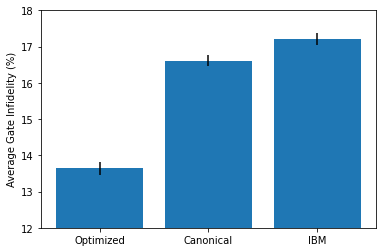

In [79]:
meas_results = (avg_opt_infidelity * 100, avg_can_infidelity * 100, avg_ibm_infidelity * 100)
meas_errors  = (100 * opt_error_bound, 100 * can_error_bound, 100 * ibm_error_bound)
x_labels = ("Optimized", "Canonical", "IBM")

plt.bar(x_labels, meas_results, yerr=meas_errors)
plt.ylim((12, 18))
plt.ylabel("Average Gate Infidelity (%)")
plt.savefig("meas_infidelity.png", dpi=400)

In [77]:
print(f"Canonical -> Optimized Infidelity Reduction: {(abs(avg_opt_infidelity - avg_can_infidelity) / avg_can_infidelity * 100)}%")

Canonical -> Optimized Infidelity Reduction: 17.92146557554232%


In [78]:
print(f"IBM -> Optimized Infidelity Reduction: {(abs(avg_opt_infidelity - avg_ibm_infidelity) / avg_ibm_infidelity * 100)}%")

IBM -> Optimized Infidelity Reduction: 20.74253562885299%
